
# Genetikus algoritmusok – **Visszahelyezési (survivor selection) módszerek** (HU)

Leggyakoribb visszahelyezési (survivor selection) stratégiák bemutatása:
- **Generációs visszahelyezés** (teljes csere)
- **Elitizmus** (a legjobbak biztos átmentése)
- **(μ, λ)** stratégia (csak utódok versenyeznek, **ES**)
- **(μ+λ)** stratégia (szülők és utódok együtt versenyeznek, **ES**)
- **Steady-state** (folyamatos kismértékű csere)
- **Age-based replacement** (életkor alapú csere)
- **Random replacement** (véletlen csere – diverzitás)

**Kulcsüzenetek:**
- GA-kban gyakori a **teljes csere + elitizmus**.
- ES-ben a **(μ, λ)**: szülők **nem élhetnek túl**, míg **(μ+λ)**: szülők **is versenyeznek**.
- Steady-state: **lassabb, stabilabb** fejlődés, gyakran magasabb diverzitás.
- Age-based: az **idősebb** egyedek esnek ki → frissül a populáció.
- A visszahelyezés **szabályozza a konvergenciát és a diverzitást**.


In [1]:

import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
random.seed(7)
np.random.seed(7)

# --- Probléma: OneMax (bináris) ---
def init_population(pop_size=40, bits=32):
    pop = np.random.randint(0, 2, size=(pop_size, bits), dtype=int)
    ages = np.zeros(pop_size, dtype=int)
    return pop, ages

def fitness_onemax(pop):
    return np.sum(pop, axis=1).astype(float)

def tournament_select(pop, fit, k=3, n_select=None):
    if n_select is None:
        n_select = len(pop)
    out = []
    for _ in range(n_select):
        idxs = np.random.choice(len(pop), size=k, replace=False)
        best = idxs[np.argmax(fit[idxs])]
        out.append(pop[best])
    return np.array(out)

def one_point_crossover(a, b):
    if a.size < 2:
        return a.copy(), b.copy()
    pt = np.random.randint(1, a.size)
    return np.concatenate([a[:pt], b[pt:]]), np.concatenate([b[:pt], a[pt:]])

def crossover_population(mates):
    next_pop = []
    n = len(mates)
    for i in range(0, n, 2):
        a = mates[i]
        b = mates[(i+1) % n]
        c1, c2 = one_point_crossover(a, b)
        next_pop.extend([c1, c2])
    return np.array(next_pop[:n])

def mutate_bitflip(pop, p=0.01):
    flip = np.random.rand(*pop.shape) < p
    out = pop.copy()
    out[flip] = 1 - out[flip]
    return out

def plot_curves(histories, title, ylabel="Átlagos fitness"):
    # Egyetlen ábra, több görbével (szabály: külön chart; itt 1 chart = 1 plt.figure)
    plt.figure()
    for name, vals in histories.items():
        plt.plot(np.arange(len(vals)), vals, label=name)
    plt.xlabel("Generáció")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()



## 1) Visszahelyezési stratégiák – definíciók

Az alábbi függvények **csak** a túlélőket választják ki a **szülők** és **utódok** közül, a kívánt populációméretre skálázva.


In [2]:

def generational_replacement(parents, parents_fit, parents_age, offspring, offspring_fit, elite=0):
    # Teljes csere + opcionális elit megőrzés a szülőkből
    if elite > 0:
        idx = np.argsort(-parents_fit)[:elite]
        elites = parents[idx]
        elites_age = np.zeros(elite, dtype=int)  # új gen: életkort nullázzuk vagy vihetjük tovább; oktatás: 0
        rest = offspring[:len(parents)-elite]
        rest_age = np.zeros(len(rest), dtype=int)
        new_pop = np.vstack([elites, rest])
        new_age = np.concatenate([elites_age, rest_age])
        return new_pop, new_age
    else:
        new_pop = offspring[:len(parents)]
        new_age = np.zeros(len(new_pop), dtype=int)
        return new_pop, new_age

def mu_comma_lambda(parents, parents_fit, parents_age, offspring, offspring_fit, mu=None):
    # (μ, λ): csak az utódok közül választunk μ túlélőt
    if mu is None:
        mu = len(parents)
    order = np.argsort(-offspring_fit)
    keep = order[:mu]
    new_pop = offspring[keep]
    new_age = np.zeros(mu, dtype=int)
    return new_pop, new_age

def mu_plus_lambda(parents, parents_fit, parents_age, offspring, offspring_fit, mu=None):
    # (μ+λ): a szülők és utódok együtt versenyeznek, a legjobb μ marad
    if mu is None:
        mu = len(parents)
    all_pop = np.vstack([parents, offspring])
    all_fit = np.concatenate([parents_fit, offspring_fit])
    order = np.argsort(-all_fit)[:mu]
    new_pop = all_pop[order]
    new_age = np.zeros(mu, dtype=int)  # egyszerűsítés: új generáció
    return new_pop, new_age

def steady_state_replacement(parents, parents_fit, parents_age, offspring, offspring_fit, replace_k=2):
    # A leggyengébb replace_k szülőt lecseréljük a legjobb replace_k utódra
    order_p = np.argsort(parents_fit)[:replace_k]           # leggyengébb szülők indexei
    order_o = np.argsort(-offspring_fit)[:replace_k]        # legjobb utódok indexei
    new_pop = parents.copy()
    new_age = parents_age.copy()
    new_pop[order_p] = offspring[order_o]
    new_age[order_p] = 0
    return new_pop, new_age

def age_based_replacement(parents, parents_fit, parents_age, offspring, offspring_fit):
    # A legöregebb egyedek esnek ki, annyi utód lép a helyükre, amennyi befér
    n = len(parents)
    m = min(len(offspring), n)
    oldest_idx = np.argsort(-parents_age)[:m]   # legnagyobb életkor
    best_off_idx = np.argsort(-offspring_fit)[:m]
    new_pop = parents.copy()
    new_age = parents_age.copy()
    new_pop[oldest_idx] = offspring[best_off_idx]
    new_age[oldest_idx] = 0
    return new_pop, new_age

def random_replacement(parents, parents_fit, parents_age, offspring, offspring_fit, replace_k=None):
    # Véletlen szülők lecserélése véletlen utódokra
    n = len(parents)
    if replace_k is None:
        replace_k = min(len(offspring), n)//2
    idx_p = np.random.choice(n, size=replace_k, replace=False)
    idx_o = np.random.choice(len(offspring), size=replace_k, replace=False)
    new_pop = parents.copy()
    new_age = parents_age.copy()
    new_pop[idx_p] = offspring[idx_o]
    new_age[idx_p] = 0
    return new_pop, new_age



## 2) Oktatási szimulátor (OneMax) – csak a visszahelyezést variáljuk

- Egyszerű **tournament** szelekció + **egypontos** crossover + **bit-flip** mutáció (p=0.01).  
- A **különbség**: **milyen túlélőket** engedünk át a következő generációba (**replacement policy**).  
- Mutatjuk a **generációnkénti átlagos** és **legjobb** fitness trendet.


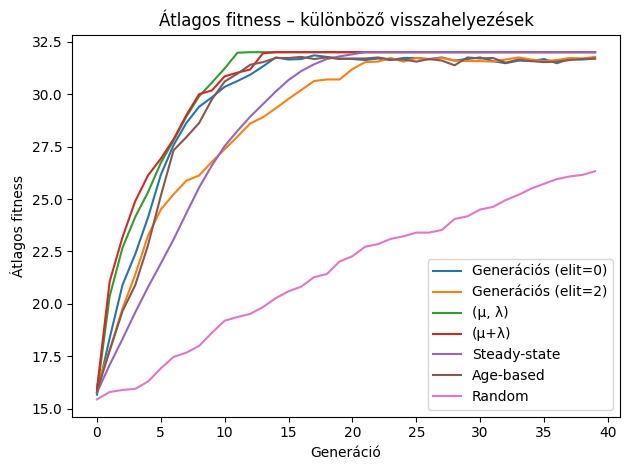

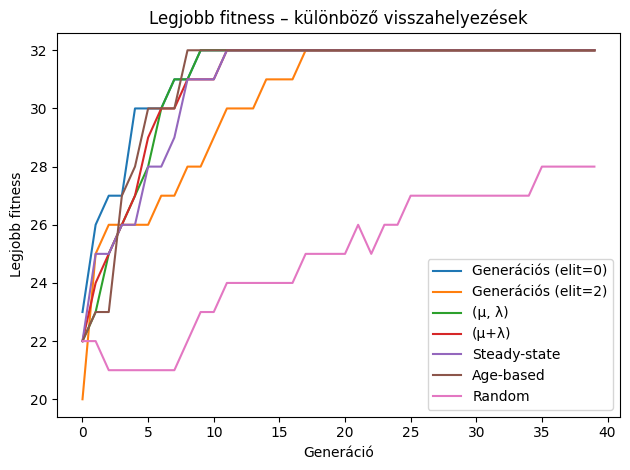

In [3]:

def evolve_with_replacement(policy_name, gens=40, pop_size=40, bits=32, elite=0, mu=None, lambda_factor=2, replace_k=2):
    # Inicializálás
    pop, ages = init_population(pop_size, bits)
    avg_hist, best_hist = [], []
    for g in range(gens):
        fit = fitness_onemax(pop)
        avg_hist.append(np.mean(fit))
        best_hist.append(np.max(fit))
        # Szelekció -> párosítás -> utódok
        mates = tournament_select(pop, fit, k=3, n_select=pop_size)
        off = crossover_population(mates)
        off = mutate_bitflip(off, p=0.01)
        off_fit = fitness_onemax(off)
        # Visszahelyezés politika
        if policy_name == "generational":
            pop, ages = generational_replacement(pop, fit, ages, off, off_fit, elite=elite)
        elif policy_name == "mu,lambda":
            lam = pop_size * lambda_factor
            mates2 = tournament_select(pop, fit, k=3, n_select=lam)
            off2 = crossover_population(mates2)
            off2 = mutate_bitflip(off2, p=0.01)
            off2_fit = fitness_onemax(off2)
            pop, ages = mu_comma_lambda(pop, fit, ages, off2, off2_fit, mu=mu or pop_size)
        elif policy_name == "mu+lambda":
            lam = pop_size * lambda_factor
            mates2 = tournament_select(pop, fit, k=3, n_select=lam)
            off2 = crossover_population(mates2)
            off2 = mutate_bitflip(off2, p=0.01)
            off2_fit = fitness_onemax(off2)
            pop, ages = mu_plus_lambda(pop, fit, ages, off2, off2_fit, mu=mu or pop_size)
        elif policy_name == "steady":
            pop, ages = steady_state_replacement(pop, fit, ages, off, off_fit, replace_k=replace_k)
        elif policy_name == "age":
            pop, ages = age_based_replacement(pop, fit, ages, off, off_fit)
        elif policy_name == "random":
            pop, ages = random_replacement(pop, fit, ages, off, off_fit, replace_k=replace_k)
        else:
            raise ValueError("Ismeretlen policy")
        # életkor növelése
        ages = ages + 1
    return np.array(avg_hist), np.array(best_hist)

# Gyors demó: több stratégia egymás mellett
gens = 40
avg_curves = {}
best_curves = {}

avg_curves["Generációs (elit=0)"], best_curves["Generációs (elit=0)"] = evolve_with_replacement("generational", gens=gens, elite=0)
avg_curves["Generációs (elit=2)"], best_curves["Generációs (elit=2)"] = evolve_with_replacement("generational", gens=gens, elite=2)
avg_curves["(μ, λ)"], best_curves["(μ, λ)"] = evolve_with_replacement("mu,lambda", gens=gens, mu=40, lambda_factor=2)
avg_curves["(μ+λ)"], best_curves["(μ+λ)"] = evolve_with_replacement("mu+lambda", gens=gens, mu=40, lambda_factor=2)
avg_curves["Steady-state"], best_curves["Steady-state"] = evolve_with_replacement("steady", gens=gens, replace_k=4)
avg_curves["Age-based"], best_curves["Age-based"] = evolve_with_replacement("age", gens=gens)
avg_curves["Random"], best_curves["Random"] = evolve_with_replacement("random", gens=gens, replace_k=8)

plot_curves(avg_curves, title="Átlagos fitness – különböző visszahelyezések", ylabel="Átlagos fitness")
plot_curves(best_curves, title="Legjobb fitness – különböző visszahelyezések", ylabel="Legjobb fitness")



## 3) Fogalmi különbségek – magyarázat (HU)

**Mi a különbség a generációs és a steady-state visszahelyezés között?**  
- *Generációs:* minden generációban **szinte minden** egyed lecserélődik (teljes csere), gyakran **gyors** változás, de **diverzitásvesztés** kockázat.  
- *Steady-state:* csak **néhány** egyedet cserélünk, a populáció **folyamatosan** frissül → **stabilabb** fejlődés, jobb diverzitás.

**Hogyan működik a (μ, λ) stratégia?**  
- Létrehozunk **λ** utódot a **μ** szülőből, majd **csak az utódok** közül választjuk ki a következő **μ** túlélőt. A szülők **nem élhetnek túl** ebben a körben. (ES hagyomány.)

**Mi az elitizmus előnye és kockázata?**  
- *Előny:* a **legjobb** megoldás **nem vész el**; monoton javulást biztosíthat.  
- *Kockázat:* túl sok elit → **diverzitáscsökkenés**, korai **lokális optimum**.

**Miért lehet hasznos az age-based replacement?**  
- Az **elöregedett** egyedek kivonása **frissíti** a populációt, elősegíti a **feltárást**, és megakadályozhatja az állapot rögzülését.

**Hogyan hat a visszahelyezés az algoritmus konvergenciájára?**  
- Erős csere (generációs, nagy elit) → gyorsabb **konvergencia**, de kockázatosabb **beragadás**.  
- Kíméletes csere (steady-state, age-based, random) → **lassabb**, de **robosztusabb** fejlődés, jobb diverzitás.



## 4) Gyakorlati játék – paraméterekkel

Feladat:
- **Elitizmus** `elite=0/2/4`
- **(μ, λ)**: `lambda_factor=2/3`
- **Steady-state**: `replace_k=2/4/8`
- **Random replacement**: `replace_k` nagyobb értékkel → több véletlen csere


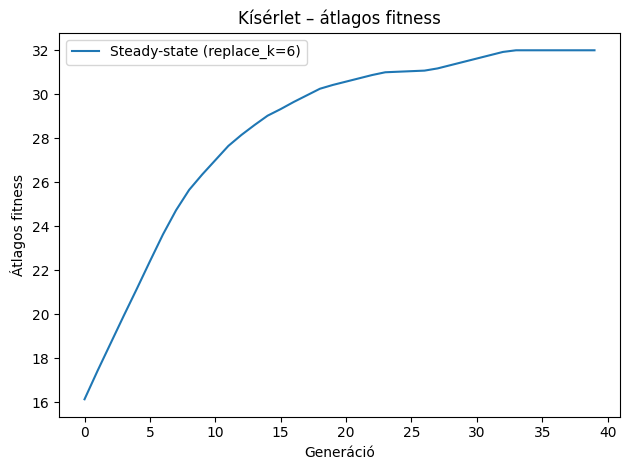

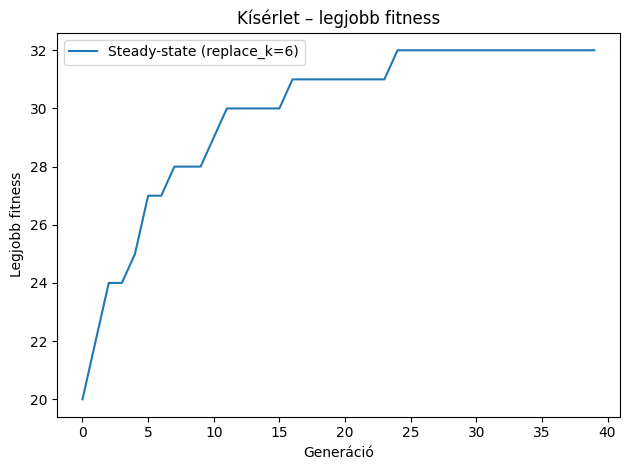

In [4]:

# Példa: változtasd a paramétereket és futtasd újra!
# Hogyan viselkedik kevesebb vagy több generációval? És Ha paramétereket változtatjuk?
avg_ex, best_ex = evolve_with_replacement("steady", gens=40, replace_k=6)
plot_curves({"Steady-state (replace_k=6)": avg_ex}, title="Kísérlet – átlagos fitness", ylabel="Átlagos fitness")
plot_curves({"Steady-state (replace_k=6)": best_ex}, title="Kísérlet – legjobb fitness", ylabel="Legjobb fitness")
